# Soil Moisture Accounting Procedure (SMAP) application example

## Importing the MOGESTpy Smap class

In [1]:
import pandas as pd

from mogestpy import Smap

### Loading the example dataset

In [2]:
df = pd.read_excel('../../datasets/Biritiba_SMAP.xlsx') # Biritiba Dataset

In [3]:
df.head() # display the first 5 rows of the dataframe

,ET,P
0,5.266667,0.0
1,5.266667,0.0
2,5.266667,0.0
3,5.266667,0.4
4,5.266667,4.2


## Initializing the Smap Class Object

In [4]:
smap = Smap()

It is possible to initialize the Smap class object with all parameters

In [5]:
smap = Smap(
    Str=100,
    k2t=1.43064763229058,
    Crec=19.612562479845,
    Ai=2,
    Capc=30,
    kkt=47.5320152819107,
    Tuin=.05,
    Ebin=0,
    Ad=70.2
)

It's also possible to edit the parameters after the initialization

In [6]:
smap = Smap()

smap.Str = 100
smap.k2t = 1.43064763229058
smap.Crec = 19.612562479845
smap.Ai = 2
smap.Capc = 30
smap.kkt = 47.5320152819107
smap.Tuin = .05
smap.Ebin = 0
smap.Ad = 70.2

The parameters are:

- $Str$ (float): Soil Saturation (mm) (default: 100)
- $Crec$ (float): Recession Coeficient (%) (default: 0)
- $Capc$ (float): Field Capacity (%) (default: 40)
- $kkt$ (float): Base flow recession coefficient (1/d) (default: 30)
- $k2t$ (float): Surface runoff recession coefficient (1/d) (default: 0.2)
- $Ad$ (float): Drainage area (km²) (default: 1)
- $Tuin$ (float): Initial soil moisture content (default: 0)
- $Ebin$ (float): Initial base flow (mm) (default: 0)
- $Ai$ (float): Initial Abstraction (-) (default: 2.5)

These information are also available at `>>> help(Smap)` in Python.

The parameter bounds can be accessed by using the `bounds()` method

In [7]:
smap.bounds()

{'Str': (100, 2000),
 'Crec': (0, 20),
 'Capc': (30, 50),
 'kkt': (30, 180),
 'k2t': (0.2, 10),
 'Ai': (2, 5)}

In [8]:
flow = smap.RunToList(df.P, df.ET)

Displaying the first 15 days of simulated flow

In [9]:
print('Day \t Flow (m³/s)')
print('-------------------')
for i, q in enumerate(flow[0:15]):
    print(f'{i+1} \t {q:.2f}')

Day 	 Flow (m³/s)
-------------------
1 	 0.00
2 	 0.00
3 	 0.00
4 	 0.00
5 	 0.00
6 	 0.02
7 	 0.01
8 	 0.41
9 	 0.25
10 	 0.16
11 	 0.10
12 	 0.06
13 	 0.04
14 	 0.05
15 	 0.03


Adding the model result to the DataFrame `df`

In [10]:
df['Q'] = flow

### Calibration

The calibration is performed using the `Calibrate()` method

In [11]:
calibration = Smap()
calibration.Ad = 70.2
variables = ['Str', 'Crec', 'Ai', 'Capc', 'kkt']
result = calibration.Calibrate(df.P, df.ET, df.Q, variables)
calibration_flow = calibration.RunToList(df.P, df.ET)

In [12]:
print(result)

             message: Optimization terminated successfully.
             success: True
                 fun: -0.8215030239899541
                   x: [ 2.899e+02  2.000e+01  2.000e+00  3.019e+01
                        3.000e+01]
                 nit: 16
                nfev: 1341
          population: [[ 2.842e+02  1.920e+01 ...  3.026e+01  3.130e+01]
                       [ 2.821e+02  1.846e+01 ...  3.620e+01  3.777e+01]
                       ...
                       [ 2.975e+02  1.569e+01 ...  3.199e+01  4.607e+01]
                       [ 2.754e+02  1.962e+01 ...  3.090e+01  3.667e+01]]
 population_energies: [-8.215e-01 -8.010e-01 ... -8.017e-01 -8.159e-01]
                 jac: [ 1.554e-07 -6.364e-04  1.834e-03 -4.663e-07
                        5.704e-04]


Note that the calibration variables must be present in `Smap().bounds()`

By default, the calibration method is the `differential_evolution` from `scipy.optimize` with the KGE objective function. Since the differential evolution searches for a minimum, the objective function is multiplied by -1 for KGE. It's possible to use other objective functions by changing the `obj_func` parameter.

In [13]:
def objective(eval, pred):
    return sum(abs(eval - pred))

In [14]:
calibration = Smap()
calibration.Ad = 70.2
variables = ['Str', 'Crec', 'Ai', 'Capc', 'kkt']
result = calibration.Calibrate(df.P, df.ET, df.Q, variables, objective)
calibration_flow = calibration.RunToList(df.P, df.ET)

In [15]:
print(result)

             message: Optimization terminated successfully.
             success: True
                 fun: 1014.8482929826248
                   x: [ 3.326e+02  2.000e+01  2.000e+00  4.739e+01
                        4.335e+01]
                 nit: 11
                nfev: 1368
          population: [[ 3.060e+02  1.977e+01 ...  4.778e+01  4.342e+01]
                       [ 2.852e+02  1.983e+01 ...  4.272e+01  3.812e+01]
                       ...
                       [ 3.055e+02  1.969e+01 ...  4.762e+01  4.649e+01]
                       [ 2.746e+02  1.987e+01 ...  4.645e+01  4.321e+01]]
 population_energies: [ 1.015e+03  1.028e+03 ...  1.021e+03  1.023e+03]
                 jac: [-5.468e-03 -1.779e+00  7.552e+00  5.685e-02
                        1.553e-02]


In [16]:
from spotpy.objectivefunctions import kge

print(f'KGE: {kge(df.Q, calibration_flow):3f}')

KGE: 0.756390


### Graph

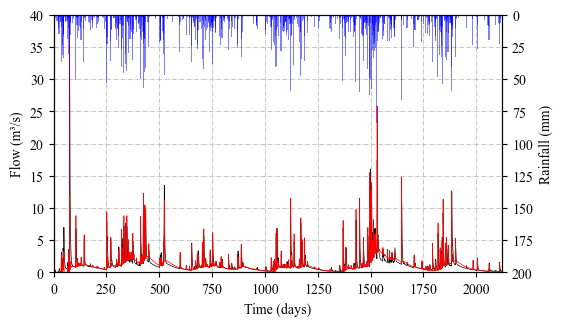

In [17]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']

fig, ax = plt.subplots(
    figsize=(140/25.4, 80/25.4),
    constrained_layout=True
    )

x_axis = [i for i in range(smap.i)]

ax.set_xlim(0, smap.i)
ax.set_ylim(0, 40)
ax.set_xlabel('Time (days)')
ax.set_ylabel('Flow (m³/s)')
prec = ax.twinx()
prec.bar(x_axis, df['P'], color='blue', width=5, zorder=1, alpha=.5)
prec.set_ylim(0,200)
prec.invert_yaxis()
prec.set_ylabel('Rainfall (mm)')
ax.plot(x_axis, flow, color='black', linewidth=.5, zorder=2)
ax.plot(x_axis, calibration_flow, color='red', linewidth=.5, zorder=2)

#plt.savefig('Datasets/Results/smap_biritiba_graph.pdf', bbox_inches='tight')
ax.grid(True, which='both', linestyle='-.', linewidth=.5)
plt.show()